# Probabilistic Programming - 3
## Variational inference

In this notebook, we are looking at inference in a dynamical system.

### Preliminaries

- Goal 
  - Learn to apply ForneyLab to a dynamical system.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Getting started with [ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).

# Kalman Filter and Message passing


Given a Gaussian linear state-space model in the form;
$$
x_k = A_kx_{k-1} + q_{k-1} \\
y_k = H_kx_k + r_k
$$
where $x_k \in \mathbb{R}^{n}$ is the state, $y_k \in \mathbb{R}^{m}$ is the measurement. Process noise and measurement noise are assumed to be zero mean Gaussian with covariance matrices $Q_k$ and $R_k$ respectively. In Bayesian notation this takes the form
$$
p(x_k | x_{k-1}) = \mathcal{N}(x_k|A_kx_{k-1},Q_{k-1})\\
p(y_k | x_k) = \mathcal{N}(y_k|H_kx_k,R_k).
$$
In Lecture 12, tracking of states of the cart with known dynamics was solved through analytic update rules of Kalman Filter. In this notebook we will investigate inference on the same model using ForneyLab. Under the hood ForneyLab constructs factor graphs corresponding to the model user specifies and performs automated inference via message passing. Without further details lets build the state space model and let ForneyLab work out the inference.


In [1]:
using LinearAlgebra, ForneyLab
include("scripts/cart_tracking_helpers.jl") # implements required factor nodes + helper functions

# Specify the model parameters
Δt = 1.0                     # assume the time steps to be equal in size
A = [1.0 Δt;
     0.0 1.0]
b = [0.5*Δt^2; Δt] 
Σz = convert(Matrix,Diagonal([0.2*Δt; 0.1*Δt])) # process noise covariance
Σx = convert(Matrix,Diagonal([1.0; 2.0]))     # observation noise covariance;

# Generate noisy observations
n = 10                # perform 10 timesteps
z_start = [10.0; 2.0] # initial state
u = 0.2 * ones(n)     # constant input u
noisy_x = generateNoisyMeasurements(z_start, u, A, b, Σz, Σx);


┌ Info: Recompiling stale cache file /Users/isenoz/.julia/compiled/v1.0/ForneyLab/Eacon.ji for ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1187
┌ Warning: Package ForneyLab does not have FastGaussQuadrature in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added FastGaussQuadrature as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading FastGaussQuadrature into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


# Model Definition with ForneyLab

In [2]:
fg = FactorGraph() #initialize a factor graph to specify a model on
#specify sufficient statistics for prior
z_prev_m = Variable(id=:z_prev_m); placeholder(z_prev_m, :z_prev_m, dims=(2,)) #mean of prior. 
z_prev_v = Variable(id=:z_prev_v); placeholder(z_prev_v, :z_prev_v, dims=(2,2)) #variance of prior
#specify control variable
bu = Variable(id=:bu); placeholder(bu, :bu, dims=(2,))
## placeholders require input from the user, you need to provide the initial values in a data dictionary 
## before and while inference

#specification of distributions
@RV z_prev ~ GaussianMeanVariance(z_prev_m, z_prev_v, id=:z_prev) # p(z_prev)
@RV noise_z ~ GaussianMeanVariance(constant(zeros(2), id=:noise_z_m), constant(Σz, id=:noise_z_v)) # process noise
@RV z = constant(A, id=:A) * z_prev + bu + noise_z; z.id = :z # p(z|z_prev) (state transition model)
@RV x ~ GaussianMeanVariance(z, constant(Σx, id=:Σx)) # p(x|z) (observation model)
placeholder(x, :x, dims=(2,)); #observation placeholder
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11008711236136428407 -->
 
 11008711236136428407 
 
 × 
 multiplication_1 
 
<!-- 14499839386733721259 -->
 
 14499839386733721259 
 
 𝒩 
 z_prev 
 
<!-- 11008711236136428407--14499839386733721259 -->
 
 11008711236136428407--14499839386733721259 
 
 z_prev 
 1 out 
 2 in1 
 
<!-- 2581530517345615175 -->
 
 2581530517345615175 
 
 A 
 
<!-- 11008711236136428407--2581530517345615175 -->
 
 11008711236136428407--2581530517345615175 
 
 A 
 1 out 
 3 a 
 
<!-- 11409150647923876599 -->
 
 11409150647923876599 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 13120693608836521265 -->
 
 13120693608836521265 
 
 noise_z_m 
 
<!-- 11409150647923876599--13120693608836521265 -->
 
 11409150647923876599--13120693608836521265 
 
 noise_z_m 
 1 out 
 2 m 
 
<!-- 7083284251565345849 -->
 
 7083284251565345849 
 
 noise_z_v 
 
<!-- 11409150647923876599--7083284251565345849 -->
 
 11409150647923876599--7083284251565345849 
 
 noise_z_v 
 1 out 
 3 v 
 
<!-- 15427756885853240244 -->
 
 15427756885853240244 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 14818470973790669898 -->
 
 14818470973790669898 
 
 Σx 
 
<!-- 15427756885853240244--14818470973790669898 -->
 
 15427756885853240244--14818470973790669898 
 
 Σx 
 1 out 
 3 v 
 
<!-- 15134528419626830983 -->
 
 15134528419626830983 
 
 + 
 addition_2 
 
<!-- 15427756885853240244--15134528419626830983 -->
 
 15427756885853240244--15134528419626830983 
 
 z 
 1 out 
 2 m 
 
<!-- 6011012471985135584 -->
 
 6011012471985135584 
 
 placeholder_z_prev_v 
 
<!-- 14499839386733721259--6011012471985135584 -->
 
 14499839386733721259--6011012471985135584 
 
 z_prev_v 
 1 out 
 3 v 
 
<!-- 10008369749899839047 -->
 
 10008369749899839047 
 
 placeholder_z_prev_m 
 
<!-- 14499839386733721259--10008369749899839047 -->
 
 14499839386733721259--10008369749899839047 
 
 z_prev_m 
 1 out 
 2 m 
 
<!-- 8910352179649730264 -->
 
 8910352179649730264 
 
 placeholder_bu 
 
<!-- 4835224913075501568 -->
 
 4835224913075501568 
 
 + 
 addition_1 
 
<!-- 4835224913075501568--11008711236136428407 -->
 
 4835224913075501568--11008711236136428407 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 4835224913075501568--8910352179649730264 -->
 
 4835224913075501568--8910352179649730264 
 
 bu 
 1 out 
 3 in2 
 
<!-- 16774017926574469853 -->
 
 16774017926574469853 
 
 placeholder_x 
 
<!-- 16774017926574469853--15427756885853240244 -->
 
 16774017926574469853--15427756885853240244 
 
 x 
 1 out 
 1 out 
 
<!-- 15134528419626830983--11409150647923876599 -->
 
 15134528419626830983--11409150647923876599 
 
 noise_z 
 1 out 
 3 in2 
 
<!-- 15134528419626830983--4835224913075501568 -->
 
 15134528419626830983--4835224913075501568 
 
 variable_2 
 1 out 
 2 in1

# Build an algorithm and infer

𝒩(m=[41.80, 5.17], v=[[1.00, 0.00][0.00, 2.00]])



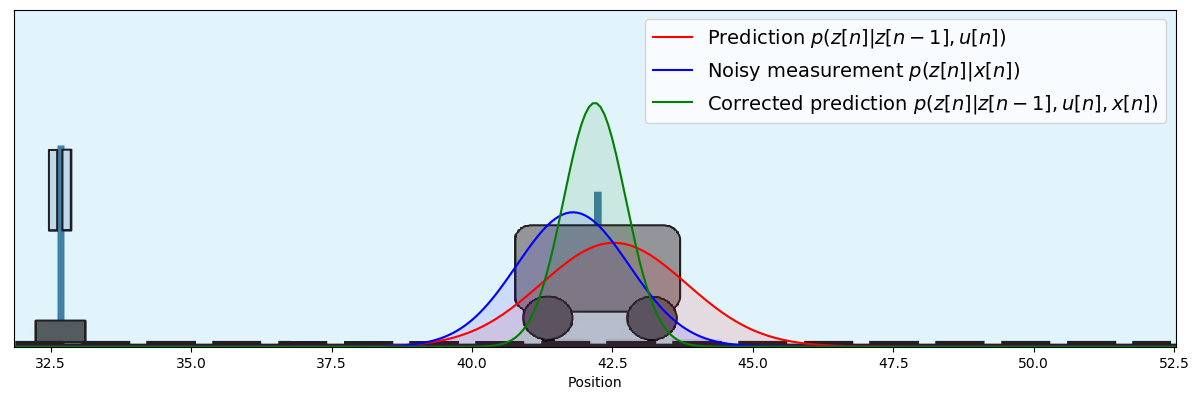

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plotCartPrediction(::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}) at cart_tracking_helpers.jl:66
└ @ Main /Users/isenoz/Documents/BMLIP/lessons/notebooks/scripts/cart_tracking_helpers.jl:66
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = plotCartPrediction(::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}, ::ProbabilityDistribution{Multivariate,GaussianMeanVariance}) at cart_tracking_helpers.jl:66
└ @ Main /Users/isenoz/Documents/BMLIP/lessons/notebooks/script

In [3]:
include("scripts/cart_tracking_helpers.jl") 
eval(Meta.parse(sumProductAlgorithm(z))) # build message passing algorithm
marginals = Dict() #initialize a marginal dictionary
messages = Array{Message}(undef,6) #messages to analyze prediction and error
z_prev_m_0 = zeros(2) #prior mean
z_prev_v_0 = 1e8*Diagonal(I,2) #prior covariance
for t=1:n
    #pass the values for placeholder to data dict
    data = Dict(:x => noisy_x[t], :bu => b*u[t],:z_prev_m => z_prev_m_0, :z_prev_v => z_prev_v_0) #data dictionary
    step!(data, marginals, messages) # perform msg passing (single timestep)
    # Posterior of z becomes prior of z in the next timestep:
    #ForneyLab.ensureParameters!(marginals[:z], (:m, :v))
    z_prev_m_0 = ForneyLab.unsafeMean(marginals[:z])
    z_prev_v_0 = ForneyLab.unsafeCov(marginals[:z])
end
println(messages[6].dist)
# Collect prediction p(z[n]|z[n-1]), measurement p(z[n]|x[n]), corrected prediction p(z[n]|z[n-1],x[n])
prediction      = messages[5].dist # the message index is found by manual inspection of the schedule
measurement     = messages[6].dist
corr_prediction = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, marginals[:z])

# Make a fancy plot of the prediction, noisy measurement, and corrected prediction after n timesteps
plotCartPrediction(prediction, measurement, corr_prediction);

# What if we don't know transition covariance?

In [4]:
fg2 = FactorGraph()
#specify sufficient statistics for prior
z_prev_m = Variable(id=:z_prev_m); placeholder(z_prev_m, :z_prev_m, dims=(2,)) #mean of prior. 
z_prev_v = Variable(id=:z_prev_v); placeholder(z_prev_v, :z_prev_v, dims=(2,2)) #variance of prior
#Wishart initialization covariance
Λz_p = Variable(id=:Λx_p); placeholder(Λz_p,:Λz_p,dims=(2,2))
ν = Variable(id=:ν); placeholder(ν,:ν)
#specify control variable
bu = Variable(id=:bu); placeholder(bu, :bu, dims=(2,))
## placeholders require input from the user, you need to provide the initial values in a data dictionary 
## before and while inference

#specification of distributions
@RV Λz ~ Wishart(Λz_p,ν)
@RV z_prev ~ GaussianMeanVariance(z_prev_m, z_prev_v, id=:z_prev) # p(z_prev)
@RV noise_z ~ GaussianMeanPrecision(constant(zeros(2), id=:noise_z_m), Λz) # process noise
@RV z = constant(A, id=:A) * z_prev + bu + noise_z; z.id = :z # p(z|z_prev) (state transition model)
@RV x ~ GaussianMeanPrecision(z, constant(Σx, id=:noise_z_v)) # p(x|z) (observation model)
placeholder(x, :x, dims=(2,)); #observation placeholder
ForneyLab.draw(fg2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9749583281515897763 -->
 
 9749583281515897763 
 
 placeholder_bu 
 
<!-- 12669967633118186019 -->
 
 12669967633118186019 
 
 W 
 wishart_1 
 
<!-- 397328138614853200 -->
 
 397328138614853200 
 
 placeholder_Λx_p 
 
<!-- 12669967633118186019--397328138614853200 -->
 
 12669967633118186019--397328138614853200 
 
 Λx_p 
 1 out 
 2 v 
 
<!-- 10734515575927424891 -->
 
 10734515575927424891 
 
 placeholder_ν 
 
<!-- 12669967633118186019--10734515575927424891 -->
 
 12669967633118186019--10734515575927424891 
 
 ν 
 1 out 
 3 nu 
 
<!-- 14403544989345228730 -->
 
 14403544989345228730 
 
 + 
 addition_2 
 
<!-- 10770579263186944366 -->
 
 10770579263186944366 
 
 + 
 addition_1 
 
<!-- 14403544989345228730--10770579263186944366 -->
 
 14403544989345228730--10770579263186944366 
 
 variable_2 
 1 out 
 2 in1 
 
<!-- 2832372415257051156 -->
 
 2832372415257051156 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 14403544989345228730--2832372415257051156 -->
 
 14403544989345228730--2832372415257051156 
 
 noise_z 
 1 out 
 3 in2 
 
<!-- 10770579263186944366--9749583281515897763 -->
 
 10770579263186944366--9749583281515897763 
 
 bu 
 1 out 
 3 in2 
 
<!-- 5051235607547984390 -->
 
 5051235607547984390 
 
 × 
 multiplication_1 
 
<!-- 10770579263186944366--5051235607547984390 -->
 
 10770579263186944366--5051235607547984390 
 
 variable_1 
 1 out 
 2 in1 
 
<!-- 1318632408170524212 -->
 
 1318632408170524212 
 
 A 
 
<!-- 6319425530888213250 -->
 
 6319425530888213250 
 
 noise_z_v 
 
<!-- 5051235607547984390--1318632408170524212 -->
 
 5051235607547984390--1318632408170524212 
 
 A 
 1 out 
 3 a 
 
<!-- 4233445966170312849 -->
 
 4233445966170312849 
 
 𝒩 
 z_prev 
 
<!-- 5051235607547984390--4233445966170312849 -->
 
 5051235607547984390--4233445966170312849 
 
 z_prev 
 1 out 
 2 in1 
 
<!-- 3851379679014154266 -->
 
 3851379679014154266 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 3851379679014154266--14403544989345228730 -->
 
 3851379679014154266--14403544989345228730 
 
 z 
 1 out 
 2 m 
 
<!-- 3851379679014154266--6319425530888213250 -->
 
 3851379679014154266--6319425530888213250 
 
 noise_z_v 
 1 out 
 3 w 
 
<!-- 13128267959772748919 -->
 
 13128267959772748919 
 
 noise_z_m 
 
<!-- 8561151280859433192 -->
 
 8561151280859433192 
 
 placeholder_z_prev_m 
 
<!-- 4233445966170312849--8561151280859433192 -->
 
 4233445966170312849--8561151280859433192 
 
 z_prev_m 
 1 out 
 2 m 
 
<!-- 12717977082489970741 -->
 
 12717977082489970741 
 
 placeholder_z_prev_v 
 
<!-- 4233445966170312849--12717977082489970741 -->
 
 4233445966170312849--12717977082489970741 
 
 z_prev_v 
 1 out 
 3 v 
 
<!-- 17092471566855443289 -->
 
 17092471566855443289 
 
 placeholder_x 
 
<!-- 17092471566855443289--3851379679014154266 -->
 
 17092471566855443289--3851379679014154266 
 
 x 
 1 out 
 1 out 
 
<!-- 2832372415257051156--12669967633118186019 -->
 
 2832372415257051156--12669967633118186019 
 
 Λz 
 1 out 
 3 w 
 
<!-- 2832372415257051156--13128267959772748919 -->
 
 2832372415257051156--13128267959772748919 
 
 noise_z_m 
 1 out 
 2 m

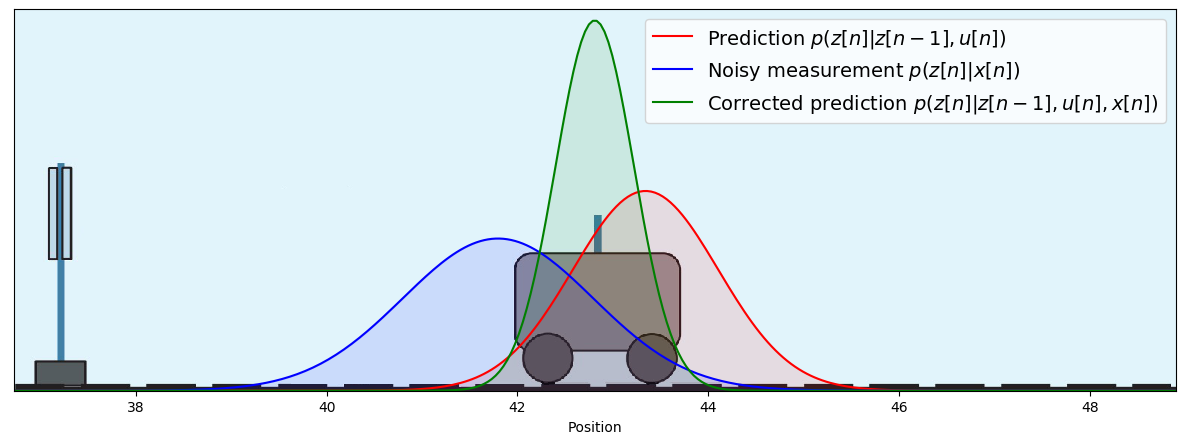

Estimated transition covariance: [0.0505664 -0.000271718; -0.000271718 0.0619175]
True covariance: [0.2 0.0; 0.0 0.1]


In [20]:
q = RecognitionFactorization(z,Λz,ids=[:Z,:Λ]);
algo = variationalAlgorithm(q)
eval(Meta.parse(algo))
marginals = Dict() #initialize a marginal dictionary
messages = Array{Message}(undef,10) #messages to analyze prediction and error
z_prev_m_0 = zeros(2) #prior mean
z_prev_v_0 = 1e8*Diagonal(I,2) #prior covariance
Λz_p0 = Diagonal(I,2)
n_its = 20
ν_0 = 20
marginals[:Λz] = vague(Wishart,2)
mz = Array{Float64}(undef,n,2)
Σz_post = Array{Float64}(undef,n,2,2)

for t=1:n
    #pass the values for placeholder to data dict
    data = Dict(:x => noisy_x[t], :bu => b*u[t],:z_prev_m => z_prev_m_0, :z_prev_v => z_prev_v_0, :Λz_p =>Λz_p0, :ν=>ν_0) #data dictionary
    for i=1:n_its
        stepZ!(data, marginals, messages) # perform msg passing (single timestep)
        stepΛ!(data, marginals)
    end
    mz[t,:], Σz_post[t,:,:] = ForneyLab.unsafeMeanCov(marginals[:z])
    z_prev_m_0, z_prev_v_0 = mz[t,:], Σz_post[t,:,:]
    Λz_p0 = marginals[:Λz].params[:v]
    ν_0 = marginals[:Λz].params[:nu]
end

prediction      = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[9].dist) # the message index is found by manual inspection of the schedule
measurement     = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[2].dist)
corr_prediction = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, marginals[:z])

# Make a fancy plot of the prediction, noisy measurement, and corrected prediction after n timesteps
plotCartPrediction(prediction, measurement, corr_prediction);
println("Estimated transition covariance: ", inv(ForneyLab.unsafeMean(marginals[:Λz])));
println("True covariance: ", Σz);